In [1]:
!pwd

/Users/shihosato/src/github.com/twinkle13531/master_degree/202012/Summary


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append(os.path.join('..', 'Random'))
sys.path.append(os.path.join('..', 'SA'))
sys.path.append(os.path.join('..', 'QA'))
sys.path.append(os.path.join('..', '4ti2', 'functions'))

In [4]:
import aws_QA_DwaveSampler_AutoEmbedding as aqa ##new
import random_exact_test_functions as ret
import SA_exact_test_functions as net
import zsolve_t1 as zt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import statistics
import math

In [5]:
time_dic = {}

In [6]:
y_dic = {'total_y_num':{}, 'mean_occurrence':{}, 'valid_y_num':{}}

In [7]:
per_time_dic = {}

In [8]:
mean_broken_chain_proportion = {}#only QA

In [9]:
p_dic = {}

In [10]:
chain_strength_dic = {20:15, 25:15, 30:15, 35:20, 40:20}
#chain_strength_dic = {20:10, 25:15, 30:20, 35:20, 40:30}

In [11]:
bit_list = [20, 25, 30, 35, 40]
num_list = [0, 1, 2, 3, 4]

## QA
計算時間の制約があるので一気に、まとめて計算する。


前回からの変更点
- calculation_time測定箇所がおかしかった→修正
- n, num_reads.たしかにnを増やすとvalid_y_numが増えるが、per_timeもcalculation_timeも*n弱ほど増える
  - どう頑張ってもvalid_y_numでSAには勝てない
  - n, num_reads = 100, 100となるとどうしても計算が時間かかりすぎる25bitでさえも
  - →n=1, num_reads=10000のtotal_timeで勝負する
  - 時間の平均、標準偏差などはtotal_timeにする（すべての手法）


In [12]:
############################################################ 本番 ##########################################################################
#n=1でのみ通用するコード
n, num_reads = 1, 10000
chain_strength_dic = {20:15, 25:15, 30:15, 35:20, 40:20}
time_dic['QA'] = {}
y_dic['total_y_num']['QA'] = {}
y_dic['mean_occurrence']['QA'] = {}
y_dic['valid_y_num']['QA'] = {}
per_time_dic['QA'] = {}
p_dic['QA'] = {}

for bit in bit_list:
    time_dic['QA'][bit] = {}
    y_dic['total_y_num']['QA'][bit] = {}
    y_dic['mean_occurrence']['QA'][bit] = {}
    y_dic['valid_y_num']['QA'][bit] = {}
    per_time_dic['QA'][bit] = {}
    mean_broken_chain_proportion[bit] = {}
    p_dic['QA'][bit] = {}
    chain_strength = chain_strength_dic[bit]
    
    for num in num_list:
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        bqm = aqa.make_Hamiltonian(df)
        res = aqa.aws_get_response(bqm, chain_strength, num_reads)
        ads = aqa.aws_DSampler(df, bqm, num_reads, chain_strength, res)
        valid_y_info_dic = ads.find_valid_y()
        
        if len(valid_y_info_dic) > 0:
            calculation_time = res.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']*10**(-6)
            occurrence_list = [valid_y_info[0] for valid_y_info in list(valid_y_info_dic.values())]
            broken_list = [valid_y_info[1] for valid_y_info in list(valid_y_info_dic.values())]

            time_dic['QA'][bit][num] = calculation_time
            y_dic['total_y_num']['QA'][bit][num] = sum(occurrence_list)
            y_dic['mean_occurrence']['QA'][bit][num] = statistics.mean(occurrence_list)
            y_dic['valid_y_num']['QA'][bit][num] = len(valid_y_info_dic)
            #per_time_dic['QA'][bit][num] = calculation_time / sum(occurrence_list)
            per_time_dic['QA'][bit][num] = calculation_time / len(valid_y_info_dic)
            mean_broken_chain_proportion[bit][num] = statistics.mean(broken_list)
            p_dic['QA'][bit][num] = ads.p_value(valid_y_info_dic)

    print('{} finish'.format(bit))

20 finish
25 finish
30 finish
35 finish
40 finish


In [13]:
time_dic['QA']

{20: {0: 2.400311, 1: 2.400274, 2: 2.400298, 3: 2.400309, 4: 2.400321},
 25: {0: 2.400341,
  1: 2.4003799999999997,
  2: 2.400337,
  3: 2.40036,
  4: 2.400341},
 30: {0: 2.4004179999999997,
  1: 2.4004179999999997,
  2: 2.400416,
  3: 2.400374,
  4: 2.400376},
 35: {0: 2.4004149999999997,
  1: 2.400373,
  2: 2.4004939999999997,
  3: 2.4003859999999997,
  4: 2.400449},
 40: {0: 2.400465, 1: 2.400463, 2: 2.4004879999999997, 4: 2.40043}}

In [14]:
y_dic['total_y_num']['QA']

{20: {0: 590, 1: 92, 2: 342, 3: 71, 4: 23},
 25: {0: 56, 1: 317, 2: 29, 3: 3, 4: 107},
 30: {0: 116, 1: 18, 2: 23, 3: 25, 4: 382},
 35: {0: 4, 1: 10, 2: 25, 3: 14, 4: 26},
 40: {0: 19, 1: 28, 2: 5, 4: 12}}

In [15]:
y_dic['mean_occurrence']['QA']

{20: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 25: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {0: 1, 1: 1, 2: 1, 4: 1}}

In [16]:
y_dic['valid_y_num']['QA']

{20: {0: 550, 1: 82, 2: 222, 3: 68, 4: 22},
 25: {0: 55, 1: 311, 2: 29, 3: 3, 4: 106},
 30: {0: 116, 1: 17, 2: 23, 3: 25, 4: 343},
 35: {0: 4, 1: 10, 2: 25, 3: 14, 4: 26},
 40: {0: 19, 1: 28, 2: 5, 4: 12}}

In [17]:
per_time_dic['QA']

{20: {0: 0.004364201818181818,
  1: 0.029271634146341464,
  2: 0.010812153153153153,
  3: 0.035298661764705884,
  4: 0.1091055},
 25: {0: 0.04364256363636364,
  1: 0.007718263665594855,
  2: 0.08277024137931034,
  3: 0.80012,
  4: 0.02264472641509434},
 30: {0: 0.02069325862068965,
  1: 0.1412010588235294,
  2: 0.10436591304347825,
  3: 0.09601496,
  4: 0.006998180758017493},
 35: {0: 0.6001037499999999,
  1: 0.2400373,
  2: 0.09601975999999998,
  3: 0.17145614285714283,
  4: 0.09232496153846154},
 40: {0: 0.12634026315789473,
  1: 0.08573082142857143,
  2: 0.48009759999999996,
  4: 0.20003583333333333}}

In [18]:
p_dic['QA']

{20: {0: 0.2927272727272727,
  1: 0.23170731707317074,
  2: 0.27927927927927926,
  3: 0.3382352941176471,
  4: 0.45454545454545453},
 25: {0: 0.0,
  1: 0.13183279742765272,
  2: 0.06896551724137931,
  3: 0.6666666666666666,
  4: 0.44339622641509435},
 30: {0: 0.09482758620689655,
  1: 0.35294117647058826,
  2: 0.08695652173913043,
  3: 0.04,
  4: 0.0058309037900874635},
 35: {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.0, 4: 0.15384615384615385},
 40: {0: 0.0, 1: 0.0, 2: 0.4, 4: 0.0}}

In [19]:
mean_broken_chain_proportion

{20: {0: 0.0009090909090909091,
  1: 0.0006097560975609756,
  2: 0.00022522522522522523,
  3: 0.0014705882352941176,
  4: 0.004545454545454546},
 25: {0: 0.0,
  1: 0.0010289389067524115,
  2: 0.0,
  3: 0.013333333333333334,
  4: 0.0007547169811320754},
 30: {0: 0.0022988505747126436,
  1: 0.0058823529411764705,
  2: 0.0014492753623188406,
  3: 0.0026666666666666666,
  4: 0.012342079689018464},
 35: {0: 0.0,
  1: 0.005714285714285714,
  2: 0.004571428571428571,
  3: 0.01020408163265306,
  4: 0.00989010989010989},
 40: {0: 0.05, 1: 0.017857142857142856, 2: 0.01, 4: 0.0125}}

## Random

前回からの変更点
- calculation_timeをret.find_valid_y(df, num_reads)の時間とした
```python
time_0 = time.time()
valid_y_dic = ret.find_valid_y(df, num_reads)
time_1 = time.time()
calculation_time = time_1 - time_0
```

In [20]:
num_reads = 10000

time_dic['random'] = {}
y_dic['total_y_num']['random'] = {}
y_dic['mean_occurrence']['random'] = {}
y_dic['valid_y_num']['random'] = {}
per_time_dic['random'] = {}
p_dic['random'] = {}

for bit in bit_list:
    time_dic['random'][bit] = {}
    y_dic['total_y_num']['random'][bit] = {}
    y_dic['mean_occurrence']['random'][bit] = {}
    y_dic['valid_y_num']['random'][bit] = {}
    per_time_dic['random'][bit] = {}
    p_dic['random'][bit] = {}
    
    for num in num_list:
        df_path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(df_path, sep=',')
        t_list = ret.calc_marginals(df)
        
        time_0 = time.time()
        valid_y_dic = ret.find_valid_y(df, num_reads)
        time_1 = time.time()
        calculation_time = time_1 - time_0
        
        if len(valid_y_dic) > 0:
            rm = ret.Random_method(df, valid_y_dic, num_reads, t_list)
            
            mean_occurrence_list = [i for i in list(valid_y_dic.values())]
            
            time_dic['random'][bit][num] = calculation_time
            y_dic['total_y_num']['random'][bit][num] = sum(mean_occurrence_list)
            y_dic['mean_occurrence']['random'][bit][num] = statistics.mean(mean_occurrence_list)
            y_dic['valid_y_num']['random'][bit][num] = len(valid_y_dic)
            per_time_dic['random'][bit][num] = calculation_time / len(valid_y_dic)
            p_dic['random'][bit][num] = rm.p_value()
        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish
35_0 finish
35_1 finish
35_2 finish
35_3 finish
35_4 finish
40_0 finish
40_1 finish
40_2 finish
40_3 finish
40_4 finish


In [21]:
time_dic['random']

{20: {0: 0.1866309642791748,
  1: 0.14350485801696777,
  2: 0.05139613151550293,
  3: 0.1823570728302002},
 25: {0: 0.0694127082824707,
  1: 0.09376788139343262,
  2: 0.13906192779541016,
  4: 0.0739898681640625},
 30: {0: 0.06981801986694336,
  1: 0.0720367431640625,
  2: 0.12625408172607422,
  4: 0.06812310218811035},
 35: {0: 0.11685419082641602,
  1: 0.09050297737121582,
  2: 0.1396791934967041,
  3: 0.0903170108795166,
  4: 0.07364583015441895},
 40: {1: 0.07501697540283203}}

In [22]:
y_dic['total_y_num']['random']

{20: {0: 138, 1: 11, 2: 20, 3: 25},
 25: {0: 5, 1: 24, 2: 8, 4: 9},
 30: {0: 1, 1: 1, 2: 6, 4: 7},
 35: {0: 1, 1: 1, 2: 6, 3: 2, 4: 4},
 40: {1: 1}}

In [23]:
y_dic['mean_occurrence']['random']

{20: {0: 1, 1: 1, 2: 1, 3: 1},
 25: {0: 1, 1: 1, 2: 1, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {1: 1}}

In [24]:
y_dic['valid_y_num']['random']

{20: {0: 138, 1: 11, 2: 20, 3: 25},
 25: {0: 5, 1: 24, 2: 8, 4: 9},
 30: {0: 1, 1: 1, 2: 6, 4: 7},
 35: {0: 1, 1: 1, 2: 6, 3: 2, 4: 4},
 40: {1: 1}}

In [25]:
per_time_dic['random']

{20: {0: 0.0013523982918780782,
  1: 0.013045896183360706,
  2: 0.0025698065757751463,
  3: 0.0072942829132080075},
 25: {0: 0.01388254165649414,
  1: 0.003906995058059692,
  2: 0.01738274097442627,
  4: 0.008221096462673612},
 30: {0: 0.06981801986694336,
  1: 0.0720367431640625,
  2: 0.021042346954345703,
  4: 0.009731871741158622},
 35: {0: 0.11685419082641602,
  1: 0.09050297737121582,
  2: 0.023279865582784016,
  3: 0.0451585054397583,
  4: 0.018411457538604736},
 40: {1: 0.07501697540283203}}

In [26]:
p_dic['random']

{20: {0: 0.26811594202898553, 1: 0.36363636363636365, 2: 0.3, 3: 0.36},
 25: {0: 0.6, 1: 0.08333333333333333, 2: 0.125, 4: 0.2222222222222222},
 30: {0: 0.0, 1: 0.0, 2: 0.5, 4: 0.0},
 35: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.25},
 40: {1: 0.0}}

## SA
- occurrence_list = list(valid_y_info_dic.values())箇所を変更

In [29]:
num_reads = 10000
time_dic['SA'] = {}
y_dic['total_y_num']['SA'] = {}
y_dic['mean_occurrence']['SA'] = {}
y_dic['valid_y_num']['SA'] = {}
per_time_dic['SA'] = {}
p_dic['SA'] = {}

for bit in bit_list:
    time_dic['SA'][bit] = {}
    y_dic['total_y_num']['SA'][bit] = {}
    y_dic['mean_occurrence']['SA'][bit] = {}
    y_dic['valid_y_num']['SA'][bit] = {}
    per_time_dic['SA'][bit] = {}
    p_dic['SA'][bit] = {}
    
    for num in num_list:
        
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        
        res, elapsed_time = net.make_res_data(df, num_reads)
        valid_y_info_dic = net.find_valid_y(res)

        occurrence_list = list(valid_y_info_dic.values())
        
        if len(valid_y_info_dic) > 0:
            rvd = net.SA_res_valid_dic(df, res, valid_y_info_dic, num_reads)
            
            time_dic['SA'][bit][num] = elapsed_time
            y_dic['total_y_num']['SA'][bit][num] = sum(occurrence_list)
            y_dic['mean_occurrence']['SA'][bit][num] = statistics.mean(occurrence_list)
            y_dic['valid_y_num']['SA'][bit][num] = len(valid_y_info_dic)
            per_time_dic['SA'][bit][num] = elapsed_time / len(valid_y_info_dic)
            p_dic['SA'][bit][num] = rvd.calc_p_value()
            
        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish
35_0 finish
35_1 finish
35_2 finish
35_3 finish
35_4 finish
40_0 finish
40_1 finish
40_2 finish
40_3 finish
40_4 finish


In [30]:
time_dic['SA']

{20: {0: 3.918872833251953,
  1: 4.007686138153076,
  2: 4.00625205039978,
  3: 4.184743881225586,
  4: 4.213732957839966},
 25: {0: 5.841594934463501,
  1: 5.630943059921265,
  2: 5.738179922103882,
  3: 5.860843896865845,
  4: 5.522691965103149},
 30: {0: 7.20236611366272,
  1: 8.155038833618164,
  2: 6.690139055252075,
  3: 7.082858085632324,
  4: 7.141763925552368},
 35: {0: 8.781783103942871,
  1: 8.96458387374878,
  2: 9.124692916870117,
  3: 8.29393482208252,
  4: 8.372267961502075},
 40: {0: 10.700252294540405,
  1: 10.791304111480713,
  2: 11.103441953659058,
  3: 10.92179822921753,
  4: 11.46165418624878}}

In [31]:
y_dic['total_y_num']['SA']

{20: {0: 9764, 1: 9861, 2: 9864, 3: 9669, 4: 9619},
 25: {0: 9833, 1: 9827, 2: 9392, 3: 8533, 4: 9866},
 30: {0: 9732, 1: 9288, 2: 9929, 3: 9226, 4: 9911},
 35: {0: 9593, 1: 9789, 2: 9821, 3: 9573, 4: 9433},
 40: {0: 9705, 1: 9796, 2: 9680, 3: 9558, 4: 9575}}

In [32]:
y_dic['mean_occurrence']['SA']

{20: {0: 1, 1: 7, 2: 6, 3: 4, 4: 36},
 25: {0: 1, 1: 1, 2: 1, 3: 6, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}}

In [33]:
y_dic['valid_y_num']['SA']

{20: {0: 7309, 1: 1364, 2: 1634, 3: 2355, 4: 260},
 25: {0: 6744, 1: 9282, 2: 6898, 3: 1371, 4: 7825},
 30: {0: 8982, 1: 8588, 2: 9808, 3: 8914, 4: 9860},
 35: {0: 9555, 1: 9778, 2: 9818, 3: 9559, 4: 9425},
 40: {0: 9704, 1: 9795, 2: 9680, 3: 9558, 4: 9574}}

In [34]:
per_time_dic['SA']

{20: {0: 0.0005361708623959438,
  1: 0.002938186318294044,
  2: 0.0024518066403915423,
  3: 0.001776961308376045,
  4: 0.016206665222461406},
 25: {0: 0.0008661914197009937,
  1: 0.0006066519133722543,
  2: 0.0008318613978115225,
  3: 0.004274867904351455,
  4: 0.0007057753310035973},
 30: {0: 0.0008018666347876553,
  1: 0.0009495853322797117,
  2: 0.0006821104256986211,
  3: 0.0007945768550182101,
  4: 0.0007243168281493273},
 35: {0: 0.0009190772479270404,
  1: 0.0009168116050060113,
  2: 0.00092938408197903,
  3: 0.0008676571631010063,
  4: 0.0008883042929975676},
 40: {0: 0.0011026640864118308,
  1: 0.0011017155805493326,
  2: 0.0011470497886011423,
  3: 0.0011426865692841107,
  4: 0.0011971646319457675}}

In [35]:
p_dic['SA']

{20: {0: 0.22971678752223287,
  1: 0.2155425219941349,
  2: 0.3329253365973072,
  3: 0.2641188959660297,
  4: 0.4153846153846154},
 25: {0: 0.08021945432977462,
  1: 0.061947856065503126,
  2: 0.1454044650623369,
  3: 0.15681983953318746,
  4: 0.25635782747603836},
 30: {0: 0.042640837230015584,
  1: 0.31264555193292964,
  2: 0.2024877650897227,
  3: 0.10735921023109715,
  4: 0.06572008113590264},
 35: {0: 0.061224489795918366,
  1: 0.049703415831458375,
  2: 0.014565084538602566,
  3: 0.0743801652892562,
  4: 0.15183023872679044},
 40: {0: 0.038746908491343775,
  1: 0.06523736600306279,
  2: 0.03006198347107438,
  3: 0.06476250261560997,
  4: 0.025067892208063505}}

## exhaustive enumeration

In [36]:
enu_time_dic = {}
enu_time_dic[20] = [4.84, 0.02, 0.23, 0.38, 0.65]
enu_time_dic[25] = [5.47, 2894.31, 4.19, 0.23, 15.37]
enu_time_dic[30] = [120017.00, 105.15, 12792.04, 725.79, 140234.05]

In [37]:
time_dic['enumeration'] = {}
y_dic['valid_y_num']['enumeration'] = {}
per_time_dic['enumeration'] = {}
p_dic['enumeration'] = {}

In [38]:
for bit in [20, 25, 30]:
    time_dic['enumeration'][bit] = {}
    y_dic['valid_y_num']['enumeration'][bit] = {}
    per_time_dic['enumeration'][bit] = {}
    p_dic['enumeration'][bit] = {}
    
    for num in [0, 1, 2, 3, 4]:
        
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        
        zinhom_path = '../4ti2/{}bit/{}/{}bit_{}.zinhom'.format(bit, num, bit, num)
        zinhom_num, zinhom_list = zt.make_result_list(zinhom_path)
        
        if zinhom_num > 0:
            zrs = zt.zsolve_result_summerize(df, zinhom_list)
            
            time_dic['enumeration'][bit][num] = enu_time_dic[bit][num]
            y_dic['valid_y_num']['enumeration'][bit][num] = zinhom_num
            per_time_dic['enumeration'][bit][num] = enu_time_dic[bit][num] / zinhom_num
            p_dic['enumeration'][bit][num] = zrs.calucurate_p()

        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish


In [39]:
time_dic['enumeration']

{20: {0: 4.84, 1: 0.02, 2: 0.23, 3: 0.38, 4: 0.65},
 25: {0: 5.47, 1: 2894.31, 2: 4.19, 3: 0.23, 4: 15.37},
 30: {0: 120017.0, 1: 105.15, 2: 12792.04, 3: 725.79, 4: 140234.05}}

In [40]:
y_dic['valid_y_num']['enumeration']

{20: {0: 16464, 1: 1365, 2: 1638, 3: 2397, 4: 260},
 25: {0: 12600, 1: 89796, 2: 14700, 3: 1372, 4: 21000},
 30: {0: 58296, 1: 57159, 2: 429660, 3: 127440, 4: 839916}}

In [41]:
per_time_dic['enumeration']

{20: {0: 0.00029397473275024293,
  1: 1.4652014652014653e-05,
  2: 0.00014041514041514042,
  3: 0.00015853149770546517,
  4: 0.0025},
 25: {0: 0.0004341269841269841,
  1: 0.03223205933449151,
  2: 0.0002850340136054422,
  3: 0.00016763848396501459,
  4: 0.0007319047619047618},
 30: {0: 2.058751886921916,
  1: 0.0018396053114995016,
  2: 0.029772471256342227,
  3: 0.00569515065913371,
  4: 0.16696199381842944}}

In [42]:
p_dic['enumeration']

{20: {0: 0.22959183673469388,
  1: 0.2153846153846154,
  2: 0.3333333333333333,
  3: 0.2640801001251564,
  4: 0.4153846153846154},
 25: {0: 0.08333333333333333,
  1: 0.0608044901777362,
  2: 0.15306122448979592,
  3: 0.15743440233236153,
  4: 0.248},
 30: {0: 0.04459997255386304,
  1: 0.31648559282002836,
  2: 0.20353302611367127,
  3: 0.11007532956685499,
  4: 0.0675067506750675}}

## mean, std dicについて
 - enumeration入(all_mean_time, all_std_time)と、なしを作る
   - 入はせっかくなので4サンプルずつ20, 25, 30bitまで
   - なしは5サンプルずつ20-40bitまで
 - 種類
   - time
   - per_time
   - valid_y_num
   - p_value//
   
   - total_y_num
   - mean_occurrence

In [72]:
method_list_all = ['enumeration', 'random', 'SA', 'QA']
method_list_40 = ['random', 'SA', 'QA']

bit_list_30 = [20, 25, 30]
bit_list_35 = [20, 25, 30, 35]
bit_list_40 = [20, 25, 30, 35, 40]
#bit_list_all = [20, 25, 30, 35, 40]

In [73]:
import statistics
import numpy as np

### time

In [74]:
mean_time_30 = {}
std_time_30 = {}
for method in method_list_all:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_30:
        time_list = list(time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_time_30[method] = np.array(mean_time_list)
    std_time_30[method] = np.array(std_time_list)

In [75]:
mean_time_30

{'enumeration': array([1.2240000e+00, 5.8391400e+02, 5.4774806e+04]),
 'random': array([0.14097226, 0.0940581 , 0.08405799]),
 'SA': array([4.06625757, 5.71885076, 7.2544332 ]),
 'QA': array([2.4003026, 2.4003518, 2.4004004])}

In [76]:
std_time_30

{'enumeration': array([1.81961095e+00, 1.15520876e+03, 6.20200715e+04]),
 'random': array([0.05437765, 0.02754795, 0.02440142]),
 'SA': array([0.11361473, 0.12791234, 0.48463631]),
 'QA': array([1.60573970e-05, 1.62160414e-05, 2.07615028e-05])}

In [77]:
mean_time_40 = {}
std_time_40 = {}
for method in method_list_40:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_40:
        time_list = list(time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_time_40[method] = np.array(mean_time_list)
    std_time_40[method] = np.array(std_time_list)

In [78]:
mean_time_40

{'random': array([0.14097226, 0.0940581 , 0.08405799, 0.10219984, 0.07501698]),
 'SA': array([ 4.06625757,  5.71885076,  7.2544332 ,  8.70745254, 10.99569016]),
 'QA': array([2.4003026, 2.4003518, 2.4004004, 2.4004234, 2.4004615])}

In [79]:
std_time_40

{'random': array([0.05437765, 0.02754795, 0.02440142, 0.02329292, 0.        ]),
 'SA': array([0.11361473, 0.12791234, 0.48463631, 0.3252927 , 0.26953669]),
 'QA': array([1.60573970e-05, 1.62160414e-05, 2.07615028e-05, 4.39299442e-05,
        2.06700266e-05])}

### per_time

In [80]:
mean_per_time_30 = {}
std_per_time_30 = {}

for method in method_list_all:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_30:
        time_list = list(per_time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_per_time_30[method] = np.array(mean_time_list)
    std_per_time_30[method] = np.array(std_time_list)

In [81]:
mean_per_time_30

{'enumeration': array([0.00062151, 0.00677015, 0.45260422]),
 'random': array([0.0060656 , 0.01084834, 0.04315725]),
 'SA': array([0.00478196, 0.00145707, 0.00079049]),
 'QA': array([0.03777043, 0.19137916, 0.07385467])}

In [82]:
std_per_time_30

{'enumeration': array([0.00094341, 0.01273235, 0.80535768]),
 'random': array([0.00460079, 0.00517179, 0.02806754]),
 'SA': array([5.76905101e-03, 1.41192513e-03, 9.11948198e-05]),
 'QA': array([0.03744264, 0.30541449, 0.0514849 ])}

In [83]:
mean_per_time_40 = {}
std_per_time_40 = {}

for method in method_list_40:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_40:
        time_list = list(per_time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_per_time_40[method] = np.array(mean_time_list)
    std_per_time_40[method] = np.array(std_time_list)

In [84]:
mean_per_time_40

{'random': array([0.0060656 , 0.01084834, 0.04315725, 0.0588414 , 0.07501698]),
 'SA': array([0.00478196, 0.00145707, 0.00079049, 0.00090425, 0.00113826]),
 'QA': array([0.03777043, 0.19137916, 0.07385467, 0.23998838, 0.22305113])}

In [85]:
std_per_time_40

{'random': array([0.00460079, 0.00517179, 0.02806754, 0.03861182, 0.        ]),
 'SA': array([5.76905101e-03, 1.41192513e-03, 9.11948198e-05, 2.28151902e-05,
        3.51259851e-05]),
 'QA': array([0.03744264, 0.30541449, 0.0514849 , 0.18810167, 0.15395815])}

### valid_y_num

In [86]:
mean_valid_y_num_30 = {}
std_valid_y_num_30 = {}

for method in method_list_all:
    mean_num_list = []
    std_num_list = []
    for bit in bit_list_30:
        num_list = list(y_dic['valid_y_num'][method][bit].values())
        mean_num_list.append(statistics.mean(num_list))
        std_num_list.append(statistics.pstdev(num_list))

    mean_valid_y_num_30[method] = np.array(mean_num_list)
    std_valid_y_num_30[method] = np.array(std_num_list)

In [87]:
mean_valid_y_num_30

{'enumeration': array([  4424.8,  27893.6, 302494.2]),
 'random': array([48.5 , 11.5 ,  3.75]),
 'SA': array([2584.4, 6424. , 9230.4]),
 'QA': array([188.8, 100.8, 104.8])}

In [88]:
std_valid_y_num_30

{'enumeration': array([  6058.52290249,  31593.63668589, 301814.3223854 ]),
 'random': array([51.91579721,  7.36545993,  2.77263413]),
 'SA': array([2456.41776577, 2682.94055096,  510.78512116]),
 'QA': array([192.55586202, 110.47968139, 124.60561785])}

In [89]:
mean_valid_y_num_40 = {}
std_valid_y_num_40 = {}

for method in method_list_40:
    mean_num_list = []
    std_num_list = []
    for bit in bit_list_40:
        num_list = list(y_dic['valid_y_num'][method][bit].values())
        mean_num_list.append(statistics.mean(num_list))
        std_num_list.append(statistics.pstdev(num_list))

    mean_valid_y_num_40[method] = np.array(mean_num_list)
    std_valid_y_num_40[method] = np.array(std_num_list)

In [90]:
mean_valid_y_num_40

{'random': array([48.5 , 11.5 ,  3.75,  2.8 ,  1.  ]),
 'SA': array([2584.4, 6424. , 9230.4, 9627. , 9662.2]),
 'QA': array([188.8, 100.8, 104.8,  15.8,  16. ])}

In [91]:
std_valid_y_num_40

{'random': array([51.91579721,  7.36545993,  2.77263413,  1.93907194,  0.        ]),
 'SA': array([2456.41776577, 2682.94055096,  510.78512116,  148.25248733,
          87.5634627 ]),
 'QA': array([192.55586202, 110.47968139, 124.60561785,   8.5416626 ,
          8.51469318])}

### p_value

In [92]:
mean_p_30 = {}
std_p_30 = {}

for method in method_list_all:
    mean_p_list = []
    std_p_list = []
    for bit in bit_list_30:
        p_list = list(p_dic[method][bit].values())
        mean_p_list.append(statistics.mean(p_list))
        std_p_list.append(statistics.pstdev(p_list))

    mean_p_30[method] = np.array(mean_p_list)
    std_p_30[method] = np.array(std_p_list)

In [93]:
mean_p_30

{'enumeration': array([0.2915549 , 0.14052669, 0.14844013]),
 'random': array([0.32293808, 0.25763889, 0.125     ]),
 'SA': array([0.29153763, 0.14014989, 0.14617069]),
 'QA': array([0.31929892, 0.26217224, 0.11611124])}

In [94]:
std_p_30

{'enumeration': array([0.07412885, 0.06575744, 0.10007932]),
 'random': array([0.04050172, 0.20398589, 0.21650635]),
 'SA': array([0.07402686, 0.06858134, 0.09958168]),
 'QA': array([0.0756705 , 0.2527882 , 0.12275674])}

In [95]:
mean_p_40 = {}
std_p_40 = {}

for method in method_list_40:
    mean_p_list = []
    std_p_list = []
    for bit in bit_list_40:
        #print(bit)
        p_list = list(p_dic[method][bit].values())
        mean_p_list.append(statistics.mean(p_list))
        std_p_list.append(statistics.pstdev(p_list))

    mean_p_40[method] = np.array(mean_p_list)
    std_p_40[method] = np.array(std_p_list)

In [96]:
mean_p_40

{'random': array([0.32293808, 0.25763889, 0.125     , 0.05      , 0.        ]),
 'SA': array([0.29153763, 0.14014989, 0.14617069, 0.07034068, 0.04477533]),
 'QA': array([0.31929892, 0.26217224, 0.11611124, 0.05076923, 0.1       ])}

In [97]:
std_p_40

{'random': array([0.04050172, 0.20398589, 0.21650635, 0.1       , 0.        ]),
 'SA': array([0.07402686, 0.06858134, 0.09958168, 0.04533604, 0.01708443]),
 'QA': array([0.0756705 , 0.2527882 , 0.12275674, 0.0644687 , 0.17320508])}

### total_y_num

In [98]:
mean_total_y_num_40 = {}
std_total_y_num_40 = {}

for method in method_list_40:
    mean_total_num_list = []
    std_total_num_list = []
    for bit in bit_list_40:
        total_num_list = list(y_dic['total_y_num'][method][bit].values())
        mean_total_num_list.append(statistics.mean(total_num_list))
        std_total_num_list.append(statistics.pstdev(total_num_list))

    mean_total_y_num_40[method] = np.array(mean_total_num_list)
    std_total_y_num_40[method] = np.array(std_total_num_list)

In [99]:
mean_total_y_num_40

{'random': array([48.5 , 11.5 ,  3.75,  2.8 ,  1.  ]),
 'SA': array([9755, 9490, 9617, 9641, 9662]),
 'QA': array([223, 102, 112,  15,  16])}

In [100]:
std_total_y_num_40

{'random': array([51.91579721,  7.36545993,  2.77263413,  1.93907194,  0.        ]),
 'SA': array([ 99.08077513, 509.51840006, 302.69621735, 144.56140564,
         87.76103919]),
 'QA': array([214.06073904, 112.68983983, 139.45250087,   8.48528137,
          8.48528137])}

### mean_occurrence

In [101]:
mean_occurrence_40 = {}
std_occurrence_40 = {}

for method in method_list_40:
    mean_occurrence_list = []
    std_occurrence_list = []
    for bit in bit_list_40:
        occurrence_list = list(y_dic['mean_occurrence'][method][bit].values())
        mean_occurrence_list.append(statistics.mean(occurrence_list))
        std_occurrence_list.append(statistics.pstdev(occurrence_list))

    mean_occurrence_40[method] = np.array(mean_occurrence_list)
    std_occurrence_40[method] = np.array(std_occurrence_list)

In [102]:
mean_occurrence_40

{'random': array([1, 1, 1, 1, 1]),
 'SA': array([10,  2,  1,  1,  1]),
 'QA': array([1, 1, 1, 1, 1])}

In [103]:
std_occurrence_40

{'random': array([0., 0., 0., 0., 0.]),
 'SA': array([12.72792206,  2.        ,  0.        ,  0.        ,  0.        ]),
 'QA': array([0., 0., 0., 0., 0.])}

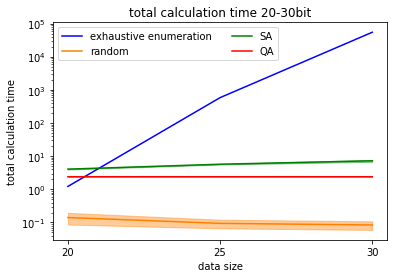

In [104]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_time_30['random'] + std_time_30['random'], mean_time_30['random'] - std_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_time_30['SA'] + std_time_30['SA'], mean_time_30['SA'] - std_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_time_30['QA'] + std_time_30['QA'], mean_time_30['QA'] - std_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('total calculation time 20-30bit')
plt.savefig('_30bit_total_calculation_time_mean_std_log.png')
plt.show()

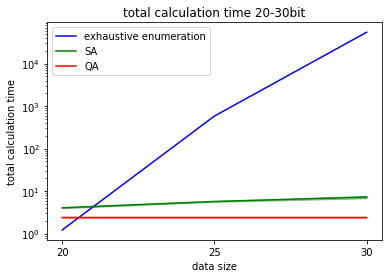

In [106]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_30, mean_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_time_30['random'] + std_time_30['random'], mean_time_30['random'] - std_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_time_30['SA'] + std_time_30['SA'], mean_time_30['SA'] - std_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_time_30['QA'] + std_time_30['QA'], mean_time_30['QA'] - std_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left')
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('total calculation time 20-30bit')
plt.savefig('norandom_30bit_total_calculation_time_mean_std_log.png')
plt.show()

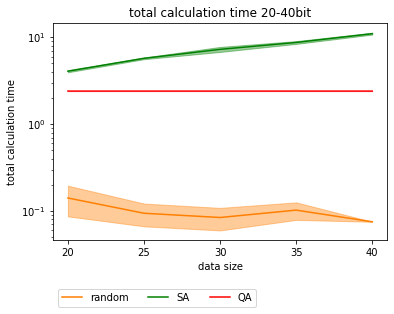

In [110]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('_40bit_total_calculation_time_mean_std_log.png')
plt.show()

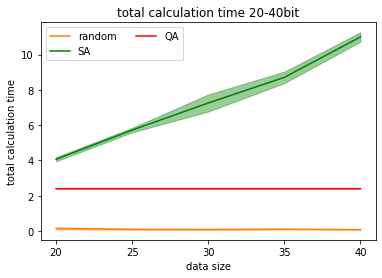

In [111]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('_40bit_total_calculation_time_mean_std.png')
plt.show()

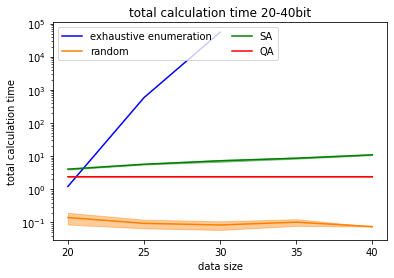

In [113]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('norandom_30bit_40bit_total_calculation_time_mean_std_log.png')
plt.show()

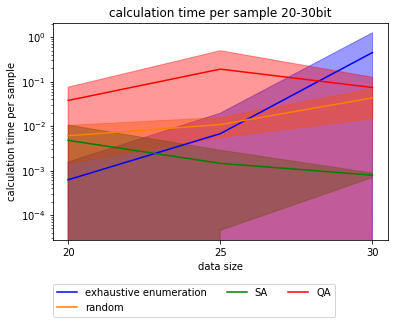

In [115]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('enustd_30bit_per_time_mean_std_log.png')
plt.show()

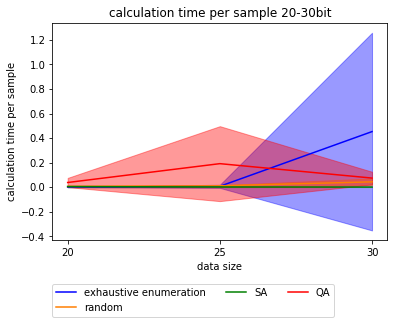

In [118]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('enustd_30bit_per_time_mean_std.png')
plt.show()

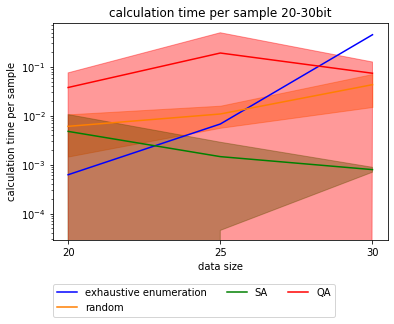

In [116]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('_30bit_per_time_mean_std_log.png')
plt.show()

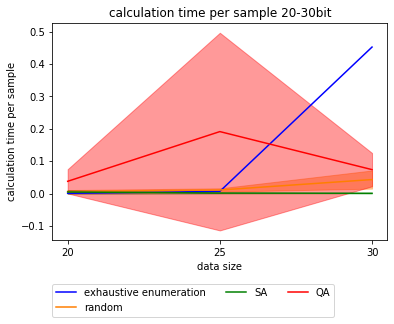

In [117]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('_30bit_per_time_mean_std.png')
plt.show()

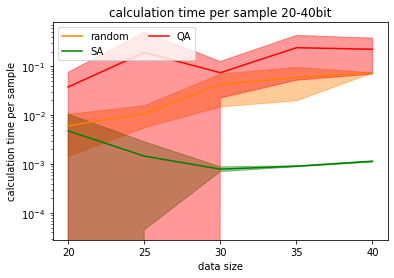

In [119]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_per_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_per_time_40['random'] + std_per_time_40['random'], mean_per_time_40['random'] - std_per_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('_40bit_per_time_mean_std_log.png')
plt.show()

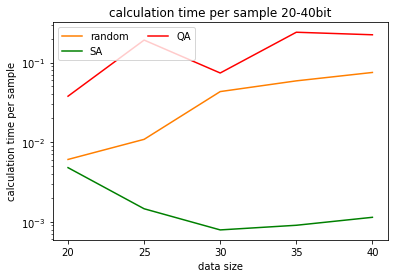

In [120]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_per_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_per_time_40['random'] + std_per_time_40['random'], mean_per_time_40['random'] - std_per_time_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('_40bit_per_time_mean_log.png')
plt.show()

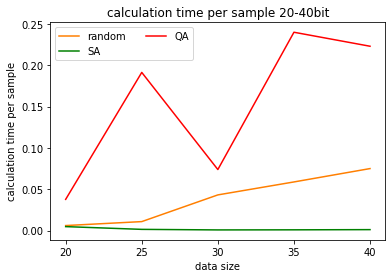

In [138]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_per_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_per_time_40['random'] + std_per_time_40['random'], mean_per_time_40['random'] - std_per_time_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('_40bit_per_time_mean.png')
plt.show()

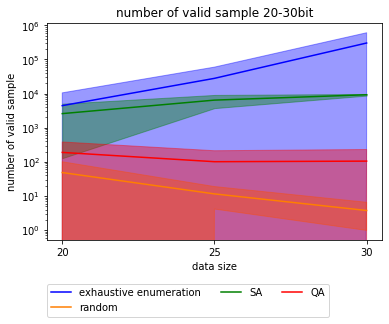

In [122]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('enustd_30bit_valid_y_num_mean_std_log.png')
plt.show()

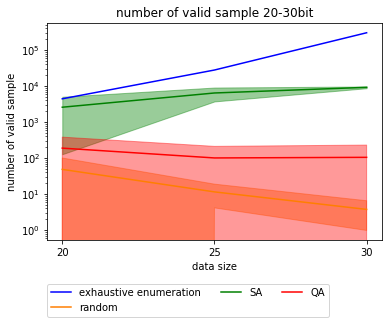

In [123]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('_30bit_valid_y_num_mean_std_log.png')
plt.show()

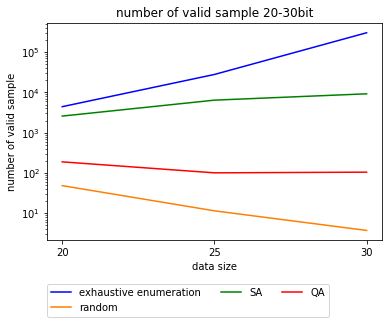

In [136]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('_30bit_valid_y_num_mean_log.png')
plt.show()

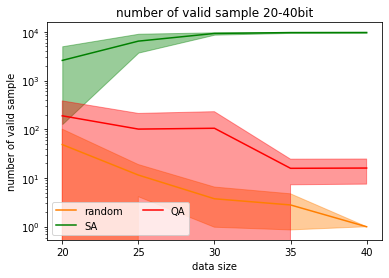

In [124]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_valid_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_valid_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_valid_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_valid_y_num_40['random'] + std_valid_y_num_40['random'], mean_valid_y_num_40['random'] - std_valid_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_valid_y_num_40['SA'] + std_valid_y_num_40['SA'], mean_valid_y_num_40['SA'] - std_valid_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_valid_y_num_40['QA'] + std_valid_y_num_40['QA'], mean_valid_y_num_40['QA'] - std_valid_y_num_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('number of valid sample 20-40bit')
plt.savefig('_40bit_valid_y_num_mean_std_log.png')
plt.show()

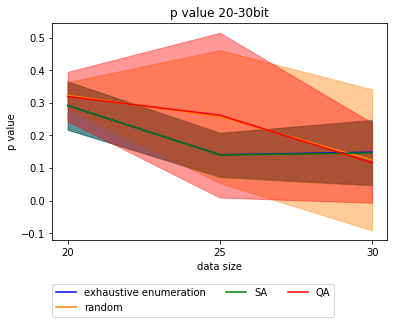

In [125]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_p_30['enumeration'] + std_p_30['enumeration'], mean_p_30['enumeration'] - std_p_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_p_30['random'] + std_p_30['random'], mean_p_30['random'] - std_p_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_p_30['SA'] + std_p_30['SA'], mean_p_30['SA'] - std_p_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_p_30['QA'] + std_p_30['QA'], mean_p_30['QA'] - std_p_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('enustd_30bit_p_mean_std.png')
plt.show()

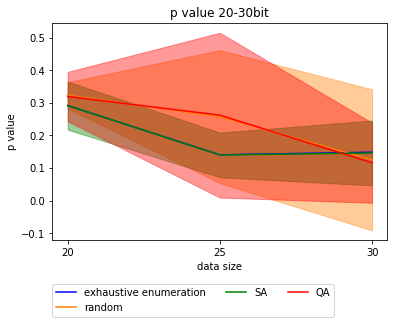

In [126]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_p_30['enumeration'] + std_p_30['enumeration'], mean_p_30['enumeration'] - std_p_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_p_30['random'] + std_p_30['random'], mean_p_30['random'] - std_p_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_p_30['SA'] + std_p_30['SA'], mean_p_30['SA'] - std_p_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_p_30['QA'] + std_p_30['QA'], mean_p_30['QA'] - std_p_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('_30bit_p_mean_std.png')
plt.show()

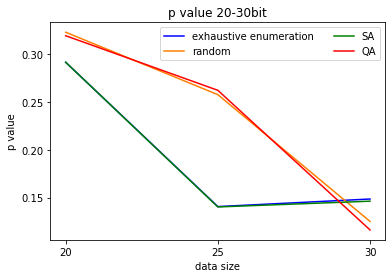

In [127]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('_30bit_p_mean.png')
plt.show()

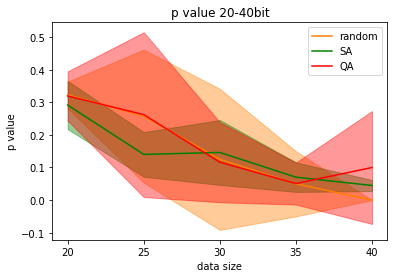

In [128]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('_40bit_p_mean_std.png')
plt.show()

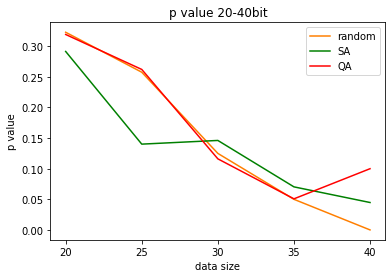

In [129]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('_40bit_p_mean.png')
plt.show()

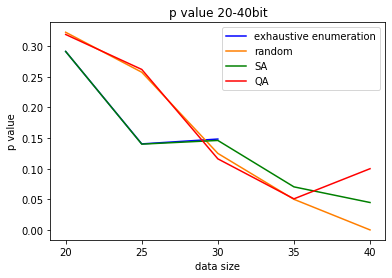

In [130]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('_30bit_40bit_p_mean.png')
plt.show()

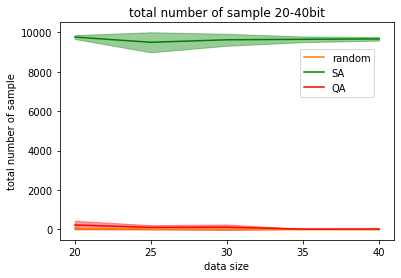

In [133]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('_40bit_total_y_num_mean_std.png')
plt.show()

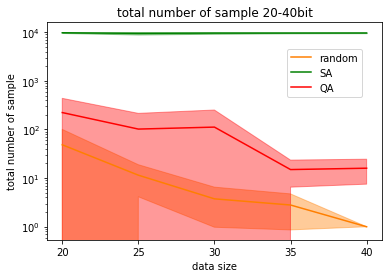

In [134]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('_40bit_total_y_num_mean_std_log.png')
plt.show()

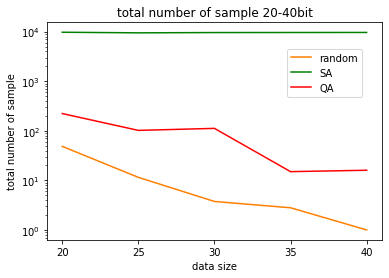

In [137]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('_40bit_total_y_num_mean_log.png')
plt.show()

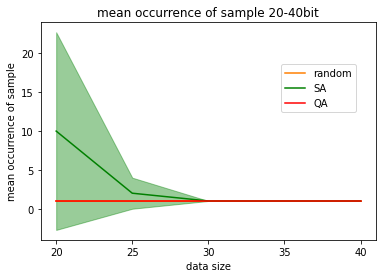

In [135]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_occurrence_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_occurrence_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_occurrence_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_occurrence_40['random'] + std_occurrence_40['random'], mean_occurrence_40['random'] - std_occurrence_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_occurrence_40['SA'] + std_occurrence_40['SA'], mean_occurrence_40['SA'] - std_occurrence_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_occurrence_40['QA'] + std_occurrence_40['QA'], mean_occurrence_40['QA'] - std_occurrence_40['QA'], alpha=0.4, color='r')

#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=2, fontsize=10)
ax.set_xlabel('data size')
ax.set_ylabel('mean occurrence of sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('mean occurrence of sample 20-40bit')
plt.savefig('_40bit_mean_occurrence_mean_std.png')
plt.show()